In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, RegularPolygon, Circle
import matplotlib as mpl


In [ ]:
red b10d2f
purple ad9ad0
green 95a84c

colorDict = {'green': '#56bc52', 'purple': '#906ae7', 'red': '#d40a00', 'grey': '#808080'}
if 'circle' in targetFeatures:
            ax.add_patch(Circle((targetx, targety),.3, fill=True, color = colorDict[targetColor], linewidth = 2))
        if 'triangle' in targetFeatures:
            ax.add_patch(RegularPolygon((targetx, targety),3,.3, fill=True, color = colorDict[targetColor], linewidth=2))
        if 'square' in targetFeatures:
            ax.add_patch(Rectangle((targetx-gridAdjust/2, targety-gridAdjust/2),.5,.5, fill=True, color = colorDict[targetColor], linewidth=2))

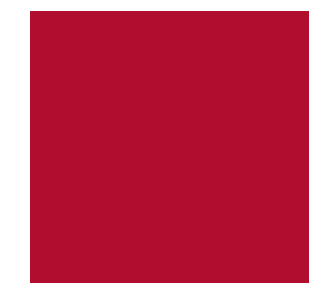

In [30]:
#circle = plt.Circle((.5, .5), 0.5, color='#95a84c')
#triangle = RegularPolygon((.5, .5),3,.5, fill=True, color = '#b10d2f')
square = Rectangle((0, 0), 1, 1, fill=True, color ='#b10d2f')
fig, ax = plt.subplots(figsize  = (5,5))
ax.axis('off')
ax.add_artist(square)

plt.savefig('redSquare.png',dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
import sys
import numpy as np
import pandas as pd
import itertools

import modelLabels as ML

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Algorithms')
sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Algorithms/ImaginedWe')
sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Environments/Experiment/')
sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Algorithms/RSA/')
sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Algorithms/JointUtility/')

import constantNames as NC


In [ ]:
import experimentConstruction as ec
from consistentSignalChecks_Experiment import SignalIsConsistent_Experiment
from visualizations_Experiment import *

from setupInference_Experiment import SetupExperiment_SignalsSeparated
from SetupRSAInference import *
from utilityOnlyModel import *

from setupModelInferences import SetupModels
from setupSampledTrials import SampleExperimentEnvironment
from setupMetrics import SimulateModelFromDF, SingleAgentUtility_TaxicabMetric, SingleAgentUtility_CustomCostFunction, CostlessReceiverUtility

# Work Through Example - Single Trial Setup, Modeling Distributions

In [ ]:
from setupSampledTrials import SampleExperimentEnvironment
sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Environments/Experiment/')
from visualizations_Experiment import *
from experimentConstruction import calculateLocationCost_TaxicabMetric
from setupModelInferences import SetupModels

## Hyper Params of the example

In [ ]:
seedNum=20
fixEnvironment_squit = False

## Sampled Environment

In [ ]:
# Scenario setups
gridDims = (9,10) #0-8, by 0-9
s = (4,0)
r = (4,7)
rationality = 4
rew = 8


itemSpace = ML.itemSpace_3Color3Shape
signalSpace = ML.featureSpace_3Color3Shape

fixedEnvironmentParameters = {'gridSize': gridDims, 'signalerPosition': s, 'receiverPosition': r}
fluidParameterSpaces = {'targets': itemSpace,'signals': signalSpace}

In [ ]:
np.random.seed(seedNum)
getEnvironment = SampleExperimentEnvironment(fixedEnvironmentParameters, fluidParameterSpaces)
goal, signalSpace, targetDict, nTargets, propRelevantVocab = getEnvironment(3, 1.0, True)

In [ ]:
environmentParameters= {'observation': {'intentions':goal}, 'signals': signalSpace, 'targetDictionary':targetDict, 'signalerLocation':s, 'receiverLocation':r}

### Alternative - Fixed Environment

In [ ]:
if fixEnvironment_squit:
    # Environment where signaler should choose to quit
    environmentParameters = {'observation': {'intentions':'red square'}, 
                        'signals': ['green', 'purple', 'triangle', 'square', 'circle', 'red'], 
                        'targetDictionary':{(0, 9): 'green circle',
                         (1, 1): 'purple circle',
                         (1, 6): 'red circle',
                         (1, 8): 'green square',
                         (5, 6): 'purple square',
                         (7, 7): 'green triangle',
                         (8, 9): 'red square'}, 
                        'signalerLocation':s, 'receiverLocation':r}

### Visualization of specific trial

In [ ]:
#Which environment parameters are goint to be used
environmentParameters

In [ ]:
visualizeExperimentTrial(gridDims, s, r, 
                         environmentParameters['signals'],
                         environmentParameters['targetDictionary'], 
                         barriers = [],
                         save=False, 
                         filename = './exptDemo.png')

## Modeling Of Environment

In [ ]:
modelParameters = {'rationality':rationality, 'reward': rew, 'costFunction': calculateLocationCost_TaxicabMetric, 'signalerInaction': True}
modelsToBuild = modelList

In [ ]:
setupInference = SetupModels(modelParameters=modelParameters, modelNames = modelsToBuild)
modelDictionary = setupInference(environmentParameters=environmentParameters)

## Modeling Distribution Results

In [ ]:
trueGoal = environmentParameters['observation']['intentions']
trueGoal

### RSA

In [ ]:
modelList

In [ ]:
RSAModelName = 'RSA_S1R1'

In [ ]:
rsa_sig = modelDictionary[RSAModelName][0](environmentParameters['observation']['intentions'])
rsa_sig.round(3)

In [ ]:
sampledSignalerChoice_RSA = rsa_sig.sample(weights = rsa_sig.columns[0]).index[0]
sampledSignalerChoice_RSA

In [ ]:
#return an empty df if the signaler chooses to go to the goal
getModelReciever = lambda modelName, signalerChoice: pd.DataFrame() if (signalerChoice == trueGoal or signalerChoice == 'quit') else modelName(signalerChoice)

rsa_rec = getModelReciever(modelDictionary[RSAModelName][1], sampledSignalerChoice_RSA)
rsa_rec.round(3)

In [ ]:
sampleReceiverChoice = lambda receiverPDF: "" if receiverPDF.shape == (0,0) else receiverPDF.sample(weights = receiverPDF.columns[0]).index[0]
sampledRecChoice_RSA = sampleReceiverChoice(rsa_rec)
sampledRecChoice_RSA

In [ ]:
if sampledRecChoice_RSA == trueGoal:
    print("For model", RSAModelName, " receiver achieves goal")
elif sampledSignalerChoice_RSA == trueGoal:
    print("For model", RSAModelName, " signaler achieves goal")
else:
    print("For model", RSAModelName, "goal is not achieved")

### Imagined We

In [ ]:
modelList

In [ ]:
IWModelName = 'IW_S1R1'

In [ ]:
iw_sig = modelDictionary[IWModelName][0]({'intentions':environmentParameters['observation']['intentions']})
iw_sig.round(3)

In [ ]:
sampledSignalerChoice_IW = iw_sig.sample(weights = iw_sig.columns[0]).index[0]
sampledSignalerChoice_IW

In [ ]:
#return an empty df if the signaler chooses to go to the goal

iw_rec = getModelReciever(modelDictionary[IWModelName][1], sampledSignalerChoice_IW)
iw_rec.round(3)

In [ ]:
sampledRecChoice_IW = sampleReceiverChoice(iw_rec)
sampledRecChoice_IW

In [ ]:
if sampledRecChoice_IW[1] == trueGoal:
    print("For model", IWModelName, " receiver achieves goal")
elif sampledSignalerChoice_IW[1] == trueGoal:
    print("For model", IWModelName, " signaler achieves goal")
else:
    print("For model", IWModelName, "goal is not achieved")

### Joint Utility

In [ ]:
ju_sig = modelDictionary['JU'][0]({'intentions':environmentParameters['observation']['intentions']})
ju_sig

In [ ]:
sampledSignalerChoice_JU = ju_sig.sample(weights = ju_sig.columns[0]).index[0]
sampledSignalerChoice_JU

In [ ]:
#return an empty df if the signaler chooses to go to the goal
ju_rec = getModelReciever(modelDictionary['JU'][1], sampledSignalerChoice_JU)
ju_rec.round(3)

In [ ]:
sampledRecChoice_JU = sampleReceiverChoice(ju_rec)
sampledRecChoice_JU

In [ ]:
if sampledRecChoice_JU[1] == trueGoal:
    print("For model Joint Utility receiver achieves goal")
elif sampledSignalerChoice_JU[1] == trueGoal:
    print("For model Joint Utility signaler achieves goal")
else:
    print("For model Joint Utility goal is not achieved")

# Small Scale Example Simulation - No Barrier Environment, Signaler Inaction and Custom Cost Options

In [ ]:
sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Simulations/')
from setupSampledTrials import SampleExperimentEnvironment
from setupModelInferences import SetupModels
from setupMetrics import SingleAgentUtility_TaxicabMetric, SimulateModelFromDF

sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Environments/Experiment/')
from experimentConstruction import calculateLocationCost_TaxicabMetric
from visualizations_Experiment import visualizeExperimentTrial_Tight

In [ ]:
randomSeed = 978
nruns = 20
signalerCanQuit = True

In [ ]:
#Fixed Parameters
alpha = 4
rewardValue = 8

#Sampling spaces
gridDims = (9,10) #0-8, by 0-9
s = (4,0)
r = (4,7)
fixedEnvironmentParameters = {'gridSize': gridDims, 'signalerPosition': s, 'receiverPosition': r}

itemSpace = ML.itemSpace_3Color3Shape
signalSpace = ML.featureSpace_3Color3Shape
fluidParameterSpaces = {'targets': itemSpace,'signals': signalSpace}

In [ ]:
#Parameters specific to this simualation:
#nItems = 3
signalProp = 1.0
prop = True

# Trial Setup
np.random.seed(randomSeed)
getEnvironment = SampleExperimentEnvironment(fixedEnvironmentParameters, fluidParameterSpaces)
simulatedTrials = pd.DataFrame(columns = ML.SAMPLED_TRIAL_PARAMETERS)

for indx in range(nruns):
    nItems = np.random.choice(range(2,10))
    goal, sigSpace, targetD, nTargets, relevantSignalProp = getEnvironment(numberOfPossibleTargets = nItems, numberOfSignals = signalProp, vocabProportion = prop)
    simulatedTrials.loc[indx] = [s, r, goal, sigSpace, targetD, nTargets, relevantSignalProp]

In [ ]:
#Setup no barrier
params = {'rationality':alpha, 'reward': rewardValue, 'costFunction': calculateLocationCost_TaxicabMetric, 'signalerInaction': signalerCanQuit}
modNames = ['RSA_S0R0', 'RSA_S1R1', 'IW_S1R0', 'IW_S1R1', 'JU']
setupModInference = SetupModels(modelParameters=params, modelNames = modNames)
getSAUtil = SingleAgentUtility_TaxicabMetric(reward = params['reward'])

In [ ]:
# Cost Receiver
getModelMetrics = SimulateModelFromDF(buildModels=setupModInference, getUtility= getSAUtil, signalerCanQuit=signalerCanQuit)
regularReceiverSimulation = simulatedTrials.apply(getModelMetrics, axis=1)

In [ ]:
simulatedTrialsWithRegReceiver = simulatedTrials.join(regularReceiverSimulation)
simulatedTrialsWithRegReceiver.loc[10:]

In [ ]:
# Special look at example 17 where quitting is likely
simulatedTrialsWithRegReceiver.loc[17][['RSA_S0R0_sChoice', 'RSA_S1R1_sChoice', 'IW_S1R0_sChoice', 'IW_S1R1_sChoice', 'JU_sChoice', 'CentralControl_utility', 'DIYSignaler_utility']]

# Small Scale Simulation with Barrier/Obstacle Environment

In [ ]:
sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Environments/Experiment/barrierConstruction/')
from utilityFromPolicyDictionary import SetupPolicyTableForEnvironment, SetupIndividualActionCost
from transitionTable import createTransitionTable

In [ ]:
def createHorizontalBarrier(yLevelBottom, xEnd1=3, xEnd2=8):
    upBarriers = [((x,yLevelBottom), (0,1)) for x in range(xEnd1, xEnd2+1)]
    downBarriers = [((x,yLevelBottom+1), (0,-1)) for x in range(xEnd1, xEnd2+1)]
    return(upBarriers+downBarriers)

### Hyper-parameters

In [ ]:
randomSeed = 978
nruns = 20
modNames = ['RSA_S0R0', 'RSA_S0R1', 'RSA_S0R2', 'IW_S1R1']
barrierHz2  = createHorizontalBarrier(2)

In [ ]:
#Fixed Parameters
alpha = 4
rewardValue = 8

#Sampling spaces
gridDims = (9,10) #0-8, by 0-9
s = (4,0)
r = (4,7)
fixedEnvironmentParameters = {'gridSize': gridDims, 'signalerPosition': s, 'receiverPosition': r}

itemSpace = ML.itemSpace_3Color3Shape
signalSpace = ML.featureSpace_3Color3Shape
fluidParameterSpaces = {'targets': itemSpace,'signals': signalSpace}

### Setup Environment Transition and Policy for a custom cost function

In [ ]:
gridWidth = 9
gridHeight = 10
actionSet = [(1,0), (-1,0), (0,1), (0,-1)]
stateSet = [(i,j) for i in range(gridWidth) for j in range(gridHeight)]

getPolicyDict = SetupPolicyTableForEnvironment(stateSet, actionSet)
policies, valueTs = getPolicyDict(barrierHz2)

getTransitionTable = createTransitionTable(gridWidth, gridHeight, actionSet)
transitionTable = getTransitionTable(barrierHz2)
getCost_barrierSet1 = SetupIndividualActionCost(policies, transitionTable, 1)

In [ ]:
sGoal = (7,4)
states = [(i,j) for i in range(9) for j in range(10)]

### Visualizations for heatmap value tables (3 environments)

In [ ]:
sns.set_context('paper')
fig, ax = plt.subplots(10,10,figsize=(20,20),sharey=True,sharex=True)

for a in range(9):
    for b in range(10):
        mat_pol = np.zeros((9,10))
        for i in range(9):
            for j in range(9,-1,-1):
                mat_pol[i,j] = valueTs[(a,b)][(i,j)]
        mat_pol = pd.DataFrame(mat_pol).transpose().loc[[x for x in range(9,-1,-1)]]

        ax[a,b] = sns.heatmap(mat_pol,cbar=False,square=True,ax=ax[a,b])

sns.despine()

In [ ]:
policies_noB, valueTs_noB = getPolicyDict([])
transitionTable_noB = getTransitionTable([])

In [ ]:
x=7
y=3

In [ ]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(5,5))



mat_pol = np.zeros((9,10))

for i in range(9):
    for j in range(9,-1,-1):
        mat_pol[i,j] = valueTs[(x,y)][(i,j)]
mat_pol = pd.DataFrame(mat_pol).transpose().loc[[x for x in range(9,-1,-1)]]

ax = sns.heatmap( mat_pol, cbar=False, square=True, ax=ax)
fig.savefig('./JUHeatmapBarrier.png',dpi=300, bbox_inches='tight')

In [ ]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(5,5))

mat_pol_nb = np.zeros((9,10))

for i in range(9):
    for j in range(9,-1,-1):
        mat_pol_nb[i,j] = valueTs_noB[(x,y)][(i,j)]
mat_pol_nb = pd.DataFrame(mat_pol_nb).transpose().loc[[x for x in range(9,-1,-1)]]

ax = sns.heatmap( mat_pol_nb, cbar=False, square=True, ax=ax)
fig.savefig('./JUHeatmapNoBarrier.png',dpi=300, bbox_inches='tight')

In [ ]:
bnrec = [((3, 5), (0, 1)),
 ((4, 5), (0, 1)),
 ((5, 5), (0, 1)),
 ((6, 5), (0, 1)),
 ((7, 5), (0, 1)),
 ((8, 5), (0, 1)),
 ((3, 6), (0, -1)),
 ((4, 6), (0, -1)),
 ((5, 6), (0, -1)),
 ((6, 6), (0, -1)),
 ((7, 6), (0, -1)),
 ((8, 6), (0, -1))]
policies_BnearRec, valueTs_BnearRec = getPolicyDict(bnrec)
transitionTable_BnearRec = getTransitionTable(bnrec)

In [ ]:
#Setup custom cost function with barrier
params_a4r8 = {'rationality':alpha, 'reward':rewardValue, 'costFunction':getCost_barrierSet1}
setupModInference = SetupModels(modelParameters=params_a4r8, modelNames = modNames)
getSAUtil = SingleAgentUtility_CustomCostFunction(reward = params_a4r8['reward'], 
                                                  getCostFunction=getCost_barrierSet1)

In [ ]:
# Cost Receiver
getModelMetrics = SimulateModelFromDF(buildModels=setupModInference, getUtility= getSAUtil)
regularReceiverSimulation = simulatedTrials.apply(getModelMetrics, axis=1)

In [ ]:
simulatedTrialsWithRegReceiver = simulatedTrials.join(regularReceiverSimulation)

# Costless Receiver

In [ ]:
from RSAExtensionForCostlessReceiver import SetupExperiment_RSASpeakerWithActionChoice_NoReceiverCost
from setupModelInferences_CostlessReceiver import SetupModels_CostlessReceiver

In [ ]:
params_a4r8 = {'rationality':4, 'reward': 8}
modNames = ['RSA_S0R0', 'RSA_S0R1', 'RSA_S1R0','RSA_S0R3', 'IW_S1R0']
setupModInference_C0R = SetupModels_CostlessReceiver(modelParameters=params_a4r8, modelNames = modNames)
getSAUtil = SingleAgentUtility_TaxicabMetric(reward = 8)
getReceiverUtil = CostlessReceiverUtility(reward = 8)

In [ ]:
getModelMetrics_R0 = SimulateModelFromDF(buildModels=setupModInference_C0R, getUtility= getSAUtil, receiverSpecificUtility = getReceiverUtil)
costlessReceiverSimulation = simulatedTrials.apply(getModelMetrics_R0, axis=1)

In [ ]:
simulatedTrialsWithCostlessReceiver = simulatedTrials.join(costlessReceiverSimulation)
simulatedTrialsWithCostlessReceiver